In [1]:
import sys
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

from models.PhysicsModel import OmniRobotDynamic
from training.TrajectoryDataset import RobotTrajectoryDataset

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
# 1. Load Dataset and Model
# Load Data
df = pd.read_csv('../dataset/processed_data/data0.csv')
print(f"Loaded data with shape: {df.shape}")

# Create Dataset to handle sequence extraction
# We want to predict a fairly long trajectory to see drift
PRED_STEPS = 200
dataset = RobotTrajectoryDataset(df, input_steps=1, target_steps=PRED_STEPS)

# Load Model
model = OmniRobotDynamic(dt=0.016)
model_path = '../models/trained/omni_robot_dynamic_weights_new.pth'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
else:
    print(f"Error: Model file not found at {model_path}")

Loaded data with shape: (9033, 11)
Model loaded successfully.


C:\Users\Gerso\AppData\Local\Temp\ipykernel_9888\4239788700.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

In [3]:
# 2. Run Prediction Loop
# Select a random sample or a specific interesting segment
sample_idx = 0  # Adjust this to look at different parts of the data
sample = dataset[sample_idx]

input_seq = sample['input_x'].unsqueeze(0).to(device)   # (1, input_steps, 7)
target_seq = sample['target_x'].unsqueeze(0).to(device) # (1, target_steps, 7)

# Initial State from input
current_state = input_seq[:, -1, 0:4] # vx, vy, omega, theta

pred_states = []

with torch.no_grad():
    for t in range(PRED_STEPS):
        # Commands are at indices 4,5,6 (vx_cmd, vy_cmd, omega_cmd)
        cmd = target_seq[:, t, 4:7]
        
        # Forward pass
        next_state = model(current_state, cmd)
        
        pred_states.append(next_state)
        current_state = next_state

predicted_trajectory = torch.stack(pred_states, dim=1)
ground_truth_trajectory = target_seq[:, :, 0:4]

# Move to CPU for plotting
predicted_np = predicted_trajectory.cpu().numpy().squeeze()     # (Steps, 4)
ground_truth_np = ground_truth_trajectory.cpu().numpy().squeeze() # (Steps, 4)

print("Prediction Complete")

Prediction Complete


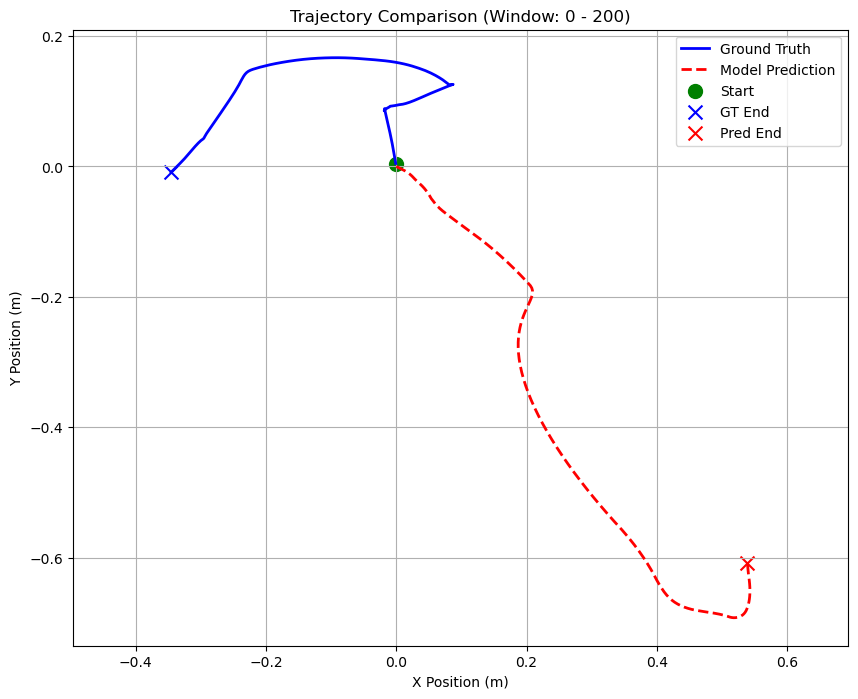

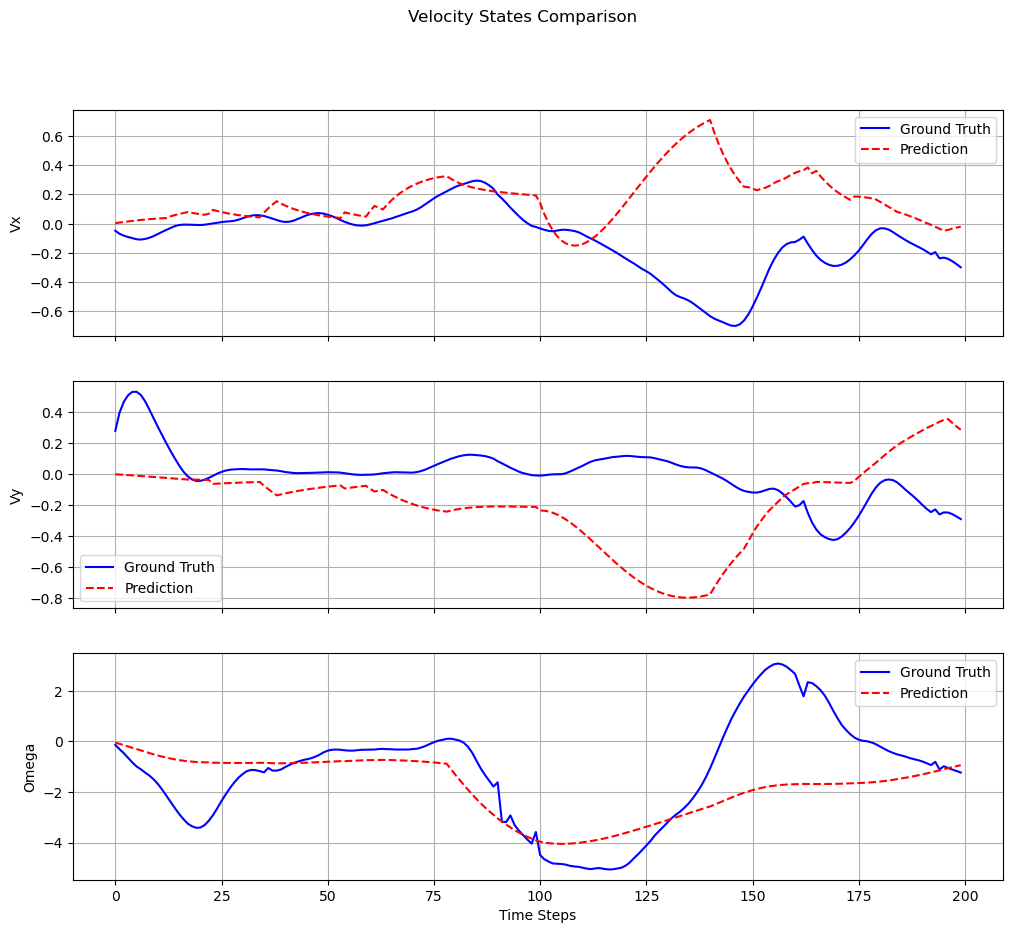

In [4]:
# 3. Integrate and Plot Trajectories
dt = 0.016

# Integrate velocities to get position (assuming start at 0,0)
pred_x = np.cumsum(predicted_np[:, 0] * dt)
pred_y = np.cumsum(predicted_np[:, 1] * dt)

gt_x = np.cumsum(ground_truth_np[:, 0] * dt)
gt_y = np.cumsum(ground_truth_np[:, 1] * dt)

# Plot Spatial Trajectory
plt.figure(figsize=(10, 8))
plt.plot(gt_x, gt_y, 'b-', label='Ground Truth', linewidth=2)
plt.plot(pred_x, pred_y, 'r--', label='Model Prediction', linewidth=2)

# Mark Start and End
plt.scatter([gt_x[0]], [gt_y[0]], c='g', marker='o', s=100, label='Start')
plt.scatter([gt_x[-1]], [gt_y[-1]], c='b', marker='x', s=100, label='GT End')
plt.scatter([pred_x[-1]], [pred_y[-1]], c='r', marker='x', s=100, label='Pred End')

plt.title(f'Trajectory Comparison (Window: {sample_idx} - {sample_idx+PRED_STEPS})')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Plot States (Vx, Vy, Omega)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

labels = ['Vx', 'Vy', 'Omega']
for i in range(3):
    axes[i].plot(ground_truth_np[:, i], 'b-', label='Ground Truth')
    axes[i].plot(predicted_np[:, i], 'r--', label='Prediction')
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Time Steps')
plt.suptitle('Velocity States Comparison')
plt.show()